##Nearest Neighbor Indexes for Similarity Search (Faiss)
In this notebook we will compare some of the most important indexes — Flat, IVF, LSH, HNSW. We will learn how we decide which to use and the impact of parameters in each index.

In [36]:
#importing the libraries

import pandas as pd
import numpy as np
import datetime as dt
import time 

In [ ]:
#loading the data into dataframe
df=pd.read_csv("/content/products.csv")

In [ ]:
%pip install faiss-cpu ##Installing GPU version of faiss

In [ ]:
%pip install sentence_transformers ## For textual similarity, using pretrained models

In [45]:
import faiss
from sentence_transformers import SentenceTransformer, util

In [ ]:
# preparing data to feed into the SentenceTransformer model

prod=df.product_name.drop_duplicates()
sentences=prod.tolist()
print("Number of Unique Sentences in Product Name ",len(sentences))

In [ ]:
# Using pretrained BERT for item embeddings.On GPU Loads the distil roberta model,which was trained on millions of data
model = SentenceTransformer('paraphrase-distilroberta-base-v1') 

In [ ]:
#Generating embeddings for each product

embeddings=model.encode(sentences)

In [ ]:
# saving the embeddings for future purposes
np.save('content\embeddings.npy', embeddings)

In [47]:
#loading the embeddings
all_embeddings=np.load('embeddings.npy')

In [48]:
#dim of bert embedding [1, 768]
d = all_embeddings.shape[1]

###Performing exhaustive search with Faiss: Flat Index

In [49]:
index = faiss.IndexFlatL2(d)
index.is_trained

True

In [50]:
index.add(all_embeddings)
index.ntotal

49688

In [52]:
start=time.time()
D, I =index.search(all_embeddings, 15)  # search
end=time.time()
print("Time taken for flat search", (end-start))

Time taken for falt search 72.22247099876404


In [54]:
#time taken by exhaustive search
Flat_time=(end-start)

###Faiss with Inverted File Index(IVF)

In [55]:
nlist = 64  # how many cells
quantizer = faiss.IndexFlatL2(d)
index_IVF = faiss.IndexIVFFlat(quantizer, d, nlist)

In [56]:
#to check if index_IVF is trained. It's False as in case of IVF we have to train the index
index_IVF.is_trained

False

In [57]:
index_IVF.train(all_embeddings)
index_IVF.is_trained  # check if index is now trained

True

In [58]:
index_IVF.add(all_embeddings)
index_IVF.ntotal  # number of embeddings indexed

49688

In [59]:
#%%time taken by IVF to find top 15 Nearest Neighbors for each unique item in the datset
start=time.time()
D_IVF, I_IVF = index_IVF.search(all_embeddings, 15)  # search
end=time.time()
IVF_time=(end-start)
IVF_time

37.35497236251831

In [60]:
#searching in 10 more near by cells
index_IVF.nprobe = 10 

In [61]:
m = 48  # number of centroid IDs in final compressed vectors
bits = 8 # number of bits in each centroid

quantizer = faiss.IndexFlatL2(d)  # we keep the same L2 distance flat index
index_PQ = faiss.IndexIVFPQ(quantizer, d, nlist, m, bits) 

In [62]:
index_PQ.is_trained

False

In [63]:
index_PQ.train(all_embeddings)
index_PQ.add(all_embeddings)

In [64]:
index_PQ.nprobe = 10  # align to previous IndexIVFFlat nprobe value

In [67]:
#%%time taken by IVF with product quantization to find top 15 Nearest Neighbors for each unique item in the datset
start=time.time()
D_PQ, I_PQ = index_PQ.search(all_embeddings, 15)  # search
end=time.time()
PQ_time=(end-start)
PQ_time

31.19085168838501

###Faiss with Locality Sensitive Hashing(LSH)

In [213]:
#number of hyperplanes
nbits = 128

# initialize the index using our vectors dimensionality (128) and nbits
index_LSH = faiss.IndexLSH(d, nbits)
# then add the data
index_LSH.train(all_embeddings)
index_LSH.add(all_embeddings)

In [214]:
#%%time
start=time.time()
D_LSH, I_LSH = index_LSH.search(all_embeddings, k=15)
end=time.time()
LSH_time=(end-start)
LSH_time

27.79438614845276

In [70]:
# we can retrieve the original vectors from wb using I
all_embeddings[I_LSH[0]].shape

(15, 768)

In [74]:
#time to search Nearest Neighbors with increasing number of hyperplanes
time_LSH=[]
for nbits in [2, 4, 8, 16, 24, 32,64,128,256, 512,768]:
    index_LSH_test = faiss.IndexLSH(d, nbits)
    index_LSH_test.add(all_embeddings)
    start=time.time()
    D_LSH_test, I_LSH_test = index_LSH_test.search(all_embeddings, k=15)
    end=time.time()
    print("TIME TAKEN with", nbits, "=",(end-start))
    time_LSH.append((nbits,(end-start)))

TIME TAKEN with 2 = 10.777793645858765
TIME TAKEN with 4 = 9.569596529006958
TIME TAKEN with 8 = 11.137335062026978
TIME TAKEN with 16 = 13.263124942779541
TIME TAKEN with 24 = 15.822367429733276
TIME TAKEN with 32 = 15.129590272903442
TIME TAKEN with 64 = 14.924017190933228
TIME TAKEN with 128 = 25.843615770339966
TIME TAKEN with 256 = 45.898590087890625
TIME TAKEN with 512 = 112.19481587409973
TIME TAKEN with 768 = 162.82570099830627


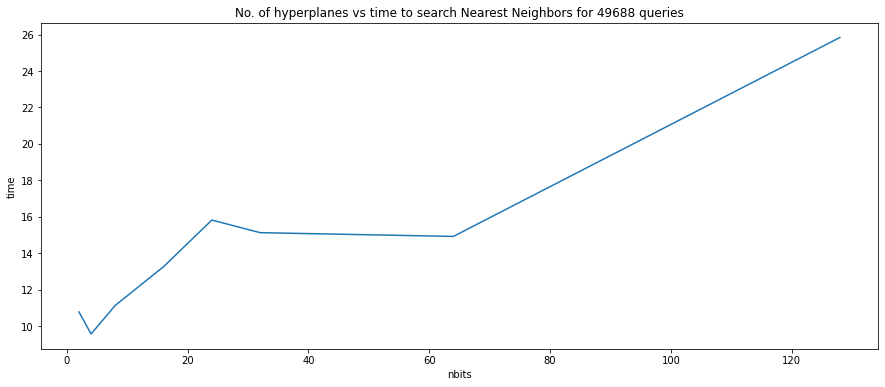

In [259]:
#ploting lineplot of No. of hyperplanes vs time to search using seaborn

x=[i[0] for i in time_LSH]
y=[i[1] for i in time_LSH]
df_LSH=pd.DataFrame({"nbits":x, "time":y})

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,6))
sns.lineplot(x = "nbits", y = "time", data=df_LSH.iloc[:8]).set(title='No. of hyperplanes vs time to search Nearest Neighbors for 49688 queries')
plt.show()

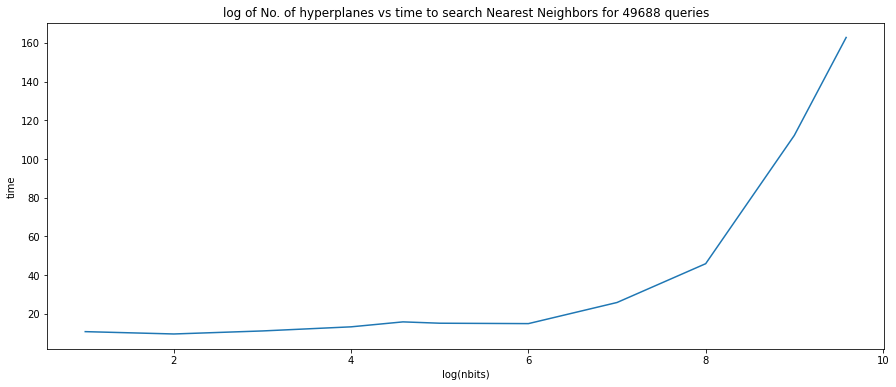

In [260]:
df_LSH['log(nbits)']=np.log2(df_LSH['nbits'])
plt.figure(figsize=(15,6))
sns.lineplot(x = "log(nbits)", y = "time", data=df_LSH).set(title='log of No. of hyperplanes vs time to search Nearest Neighbors for 49688 queries')
plt.show()

### Faiss with Hierarchical Navigable Small World Graphs(HNSW)

In [225]:
# setup our HNSW parameters
M = 32
index_HNSW=faiss.IndexHNSWFlat(d, M)

In [226]:
#index.hnsw.efConstruction = efConstruction
index_HNSW.add(all_embeddings)  # build the index
#index.hnsw.efSearch = efSearch


In [227]:
# seaech time

start=time.time()
D_HNSW, I_HNSW = index_HNSW.search(all_embeddings, k=15)
end=time.time()
HNSW_time=(end-start)
HNSW_time

26.332139253616333

In [257]:
x={"Index_Flat":Flat_time, "Index_IVF":IVF_time,"Index_IVF_PQ":PQ_time,"Index_LSH":LSH_time,"Index_HNSW":HNSW_time}

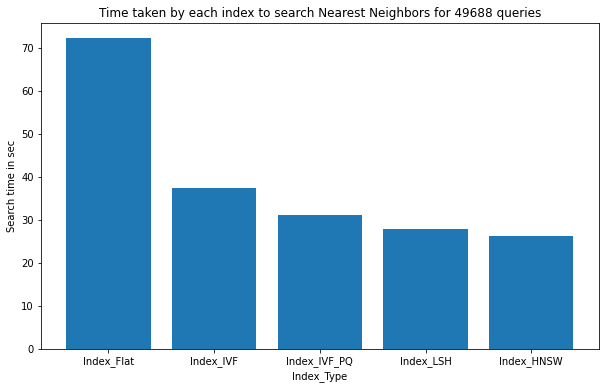

In [258]:
# Comparing serach time of all the indexes

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.bar(*zip(*x.items()))
plt.xlabel("Index_Type")
plt.ylabel("Search time in sec")
plt.title("Time taken by each index to search Nearest Neighbors for 49688 queries")
plt.show()

In [177]:
# function to return number of common elements in two lists

def intersection(list_a, list_b):
    return len([e for e in list_a if e in list_b ])

In [184]:
# function to find accracy 

def exact_match(I,index_comp,all_embeddings):
  len_IVF=0
  k=15
  for i in range(len(all_embeddings)):
    len_IVF+=intersection(I[i],index_comp[i])

  return len_IVF/(k*len(all_embeddings))*100

In [231]:
a=[]
for i in [I_IVF,I_PQ,I_LSH,I_HNSW]:
  a.append(exact_match(I,i,all_embeddings))

In [230]:
#accuracy of index_HNSW
exact_match(I,I_HNSW,all_embeddings)

95.19951161917028

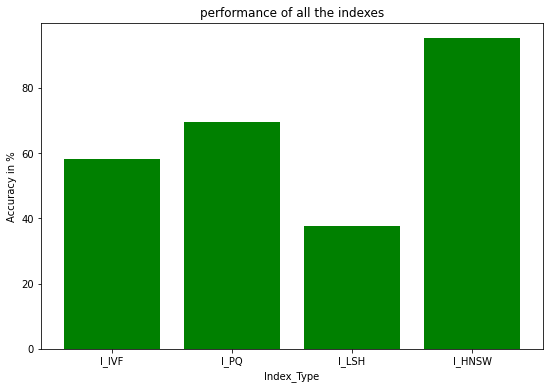

In [256]:
performance={"I_IVF":a[0],"I_PQ":a[1],"I_LSH":a[2],"I_HNSW":a[3]}
plt.figure(figsize=(9,6))
plt.bar(*zip(*performance.items()),color='green')
plt.xlabel("Index_Type")
plt.ylabel("Accuracy in %")
plt.title("performance of all the indexes")
plt.show()